In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
import pybird

### Factorizing all time dependence from PyBird...

In [2]:
zpk = .57

In [3]:
from classy import Class
M = Class()
M.set({'omega_b': 0.02237, 'omega_cdm': 0.120, 'h': 0.6736, 'ln10^{10}A_s': 3.044, 'n_s': 0.9649})
M.set({'output': 'mPk', 'P_k_max_1/Mpc': 1.0, 'z_max_pk': zpk})
M.compute()
f1 = M.scale_independent_growth_factor_f(zpk) # growth rate
kk = np.logspace(-5, 0, 200) # k in h/Mpc
pklin = np.array([M.pk(k*M.h(), zpk)*M.h()**3 for k in kk]) # P(k) in (Mpc/h)**3

In [4]:
# here we call the internal array of PyBird
kd = pybird.co.k

In [5]:
N = pybird.Correlator()

# 'with_exact_time': True, 'with_time': False : those two options are 
# for keeping all pieces multiplied with different time functions (and EFT parameters) independent
N.set({'output': 'bPk', 'multipole': 3, 'xdata': kd, 'resum': False, 'with_exact_time': True, 'with_time': False})
N.compute({'k11': kk, 'P11': pklin, 'f': f1, 'z': zpk, 'Omega0_m': M.Omega0_m()}) 

# the following computes the IR-corrections; setPs=False such that the IR-corrections are not added to the pieces
N.resum.Ps(N.bird, makeIR=True, makeQ=True, setPs=False, window=None) 
# note that no observational effects are applied on the IR-corrections (no AP, no binning, etc.)
# let me know if this is a problem!

(non-resummed) linear, loop, and counterterm pieces: shape = (nmult, nterm, nk)

you can find the (EFT parameters x time functions) multiplying each loop piece in bird.py from l. 433 to 467

In principle, for your interpolator you just need one P11 and one Pct I guess...

In [6]:
print ( N.bird.P11l.shape, N.bird.Ploopl.shape, N.bird.Pctl.shape )

(3, 3, 64) (3, 35, 64) (3, 6, 64)


IR-corrections: 

linear and counterterms: shape = (nmult, nIR, nk) (so here indeed I just use one before projecting on the multipoles)

loop: shape = (nmult, nterm, nIR, nk)

The time dependence of depends on nIR. Basically, you have: 

IR-corrections ~ X^nIR  \xi : check Eq. (9) in the PyBird paper (also Eq. (15) in 2111.05739)

In [7]:
print (N.bird.IRPs11.shape, N.bird.IRPsloop.shape, N.bird.IRPsct.shape)

(3, 96, 64) (3, 35, 96, 64) (3, 96, 64)


those are multiplied by the time functions Q (of f): shape = (norder, nmult, nmult', nIR) : check Eq. (9) in the PyBird paper and the start of resumfactor.py

Q[0] is the to resum the linear part, Q[1] is to resum the loop part : check setIRPs() in bird.py

In [8]:
print (N.bird.Q.shape)

(2, 3, 3, 96)


### Test

In [9]:
bias = { "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, 'cr1': -1.6, 'cr2': 2. }
bpk = N.get(bias)

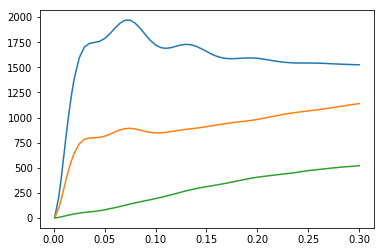

In [10]:
for i in range(3): plt.plot(kd, kd*bpk[i])